TITLE

INTRODUCTION
The data below has been collected from 123 different patients and reports on specific aspects of their health with the purpose of determining the presence of heart disease in a patient. Similar data has been collected from hospitals in Budapest, Cleveland, and Switzerland, originally with 76 different variables. For the purposes of this project, the data used will only contain 14 variables, and is taken from the University hospital in Switzerland. The question to be answered is: How present is heart disease in a patient, with categorical values ranging from 0 (no heart disease present) to 4?


PRELIMINARY DATA ANALYSIS

In [253]:
#run this cell first
library(tidyverse)
library(digest)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

In [254]:
# read in the heart disease data, rename the column name and mutate all columns to be numeric
heart_disease_data <- read_csv("processed.switzerland.data", col_names = FALSE) %>%
                        mutate_if(is.character, as.numeric) %>%
                        rename(age = X1, sex = X2, chest_pain_type = X3, resting_BP = X4, cholesteral = X5, fasting_bs = X6, rest_ecg = X7,
                                  max_hr = X8, ex_angina = X9, st_depression = X10, slope_st = X11, num_major_vessels = X12, thal = X13, diagnosis = X14)

Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_character(),
  X5 = col_double(),
  X6 = col_character(),
  X7 = col_character(),
  X8 = col_character(),
  X9 = col_character(),
  X10 = col_character(),
  X11 = col_character(),
  X12 = col_character(),
  X13 = col_character(),
  X14 = col_double()
)

Warning message:
“Problem with `mutate()` input `X4`.
ℹ NAs introduced by coercion
ℹ Input `X4` is `.Primitive("as.double")(X4)`.”
Warning message in mask$eval_all_mutate(dots[[i]]):
“NAs introduced by coercion”
Warning message:
“Problem with `mutate()` input `X6`.
ℹ NAs introduced by coercion
ℹ Input `X6` is `.Primitive("as.double")(X6)`.”
Warning message in mask$eval_all_mutate(dots[[i]]):
“NAs introduced by coercion”
Warning message:
“Problem with `mutate()` input `X7`.
ℹ NAs introduced by coercion
ℹ Input `X7` is `.Primitive("as.double")(X7)`.”
Warning message in mask$eval_all_mutate(dots[[i]]):
“NAs introduced by coerci

In [255]:
# mutate the diagnosis column to be a factor
heart_disease_data <- mutate(heart_disease_data, diagnosis = as.factor(diagnosis))

# Select useful columns , remove any rows that contain NA
heart_disease_data <- select(heart_disease_data, age, sex, chest_pain_type, resting_BP, rest_ecg, max_hr, ex_angina, st_depression, slope_st, thal, diagnosis) %>%
                        na.omit()
heart_disease_data

age,sex,chest_pain_type,resting_BP,rest_ecg,max_hr,ex_angina,st_depression,slope_st,thal,diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
36,1,4,110,0,125,1,1,2,6,1
38,0,4,110,0,156,0,0,2,3,1
38,1,3,115,0,128,1,0,2,7,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
70,1,4,115,1,92,1,0,2,7,1
70,1,4,140,0,157,1,2,2,7,3
73,0,3,160,1,121,0,0,1,3,1


In [259]:
# Group by diagnosis and find average age, resting blood pressure and maximum heart rate achieved, 
# and the number of observations

heart_disease_table <- heart_disease_data %>%
                        select(age,resting_BP, max_hr, diagnosis)%>%
                        group_by(diagnosis)%>%
                        summarize(avg_age = round(mean(age), digits = 1),
                                  avg_resting_BP = round(mean(resting_BP)),
                                  avg_max_hr = round(mean(max_hr)),
                                  num_obs = n())
heart_disease_table

`summarise()` ungrouping output (override with `.groups` argument)



diagnosis,avg_age,avg_resting_BP,avg_max_hr,num_obs
<fct>,<dbl>,<dbl>,<dbl>,<int>
0,56.0,120,97,1
1,55.4,133,116,16
2,55.0,138,116,18
3,58.5,139,110,17
4,52.0,122,112,3


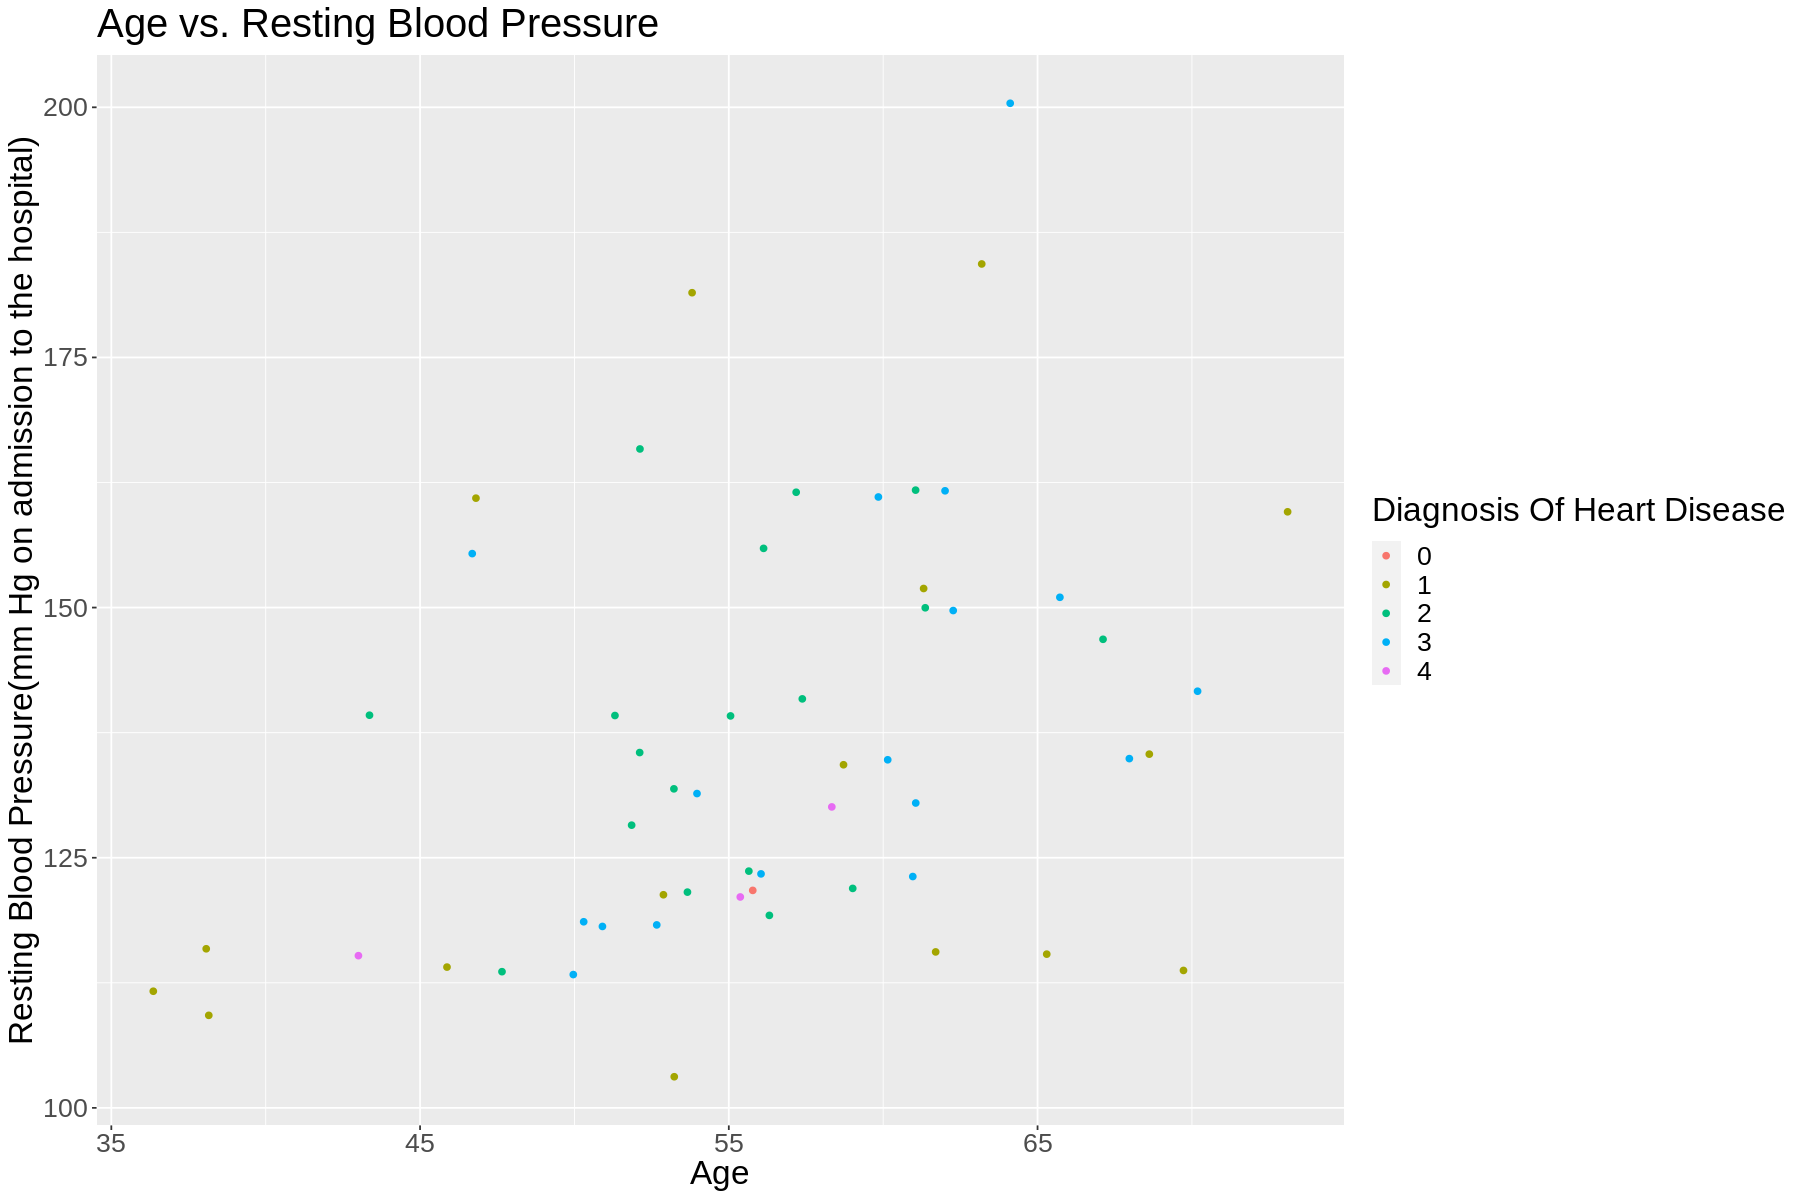

In [263]:
# Plot for age vs. resting blood pressure

options(repr.plot.width = 15, repr.plot.height = 10)

resting_BP_plot <- heart_disease_data %>%
                    ggplot(aes(x = age, y = resting_BP, color = diagnosis))+
                    geom_point(position = "jitter")+
                    labs(x = "Age", y = "Resting Blood Pressure(mm Hg on admission to the hospital)", colour = "Diagnosis Of Heart Disease")+
                    ggtitle("Age vs. Resting Blood Pressure")+
                    theme(text = element_text(size = 20))+
                    scale_y_continuous(labels = scales::comma)
resting_BP_plot

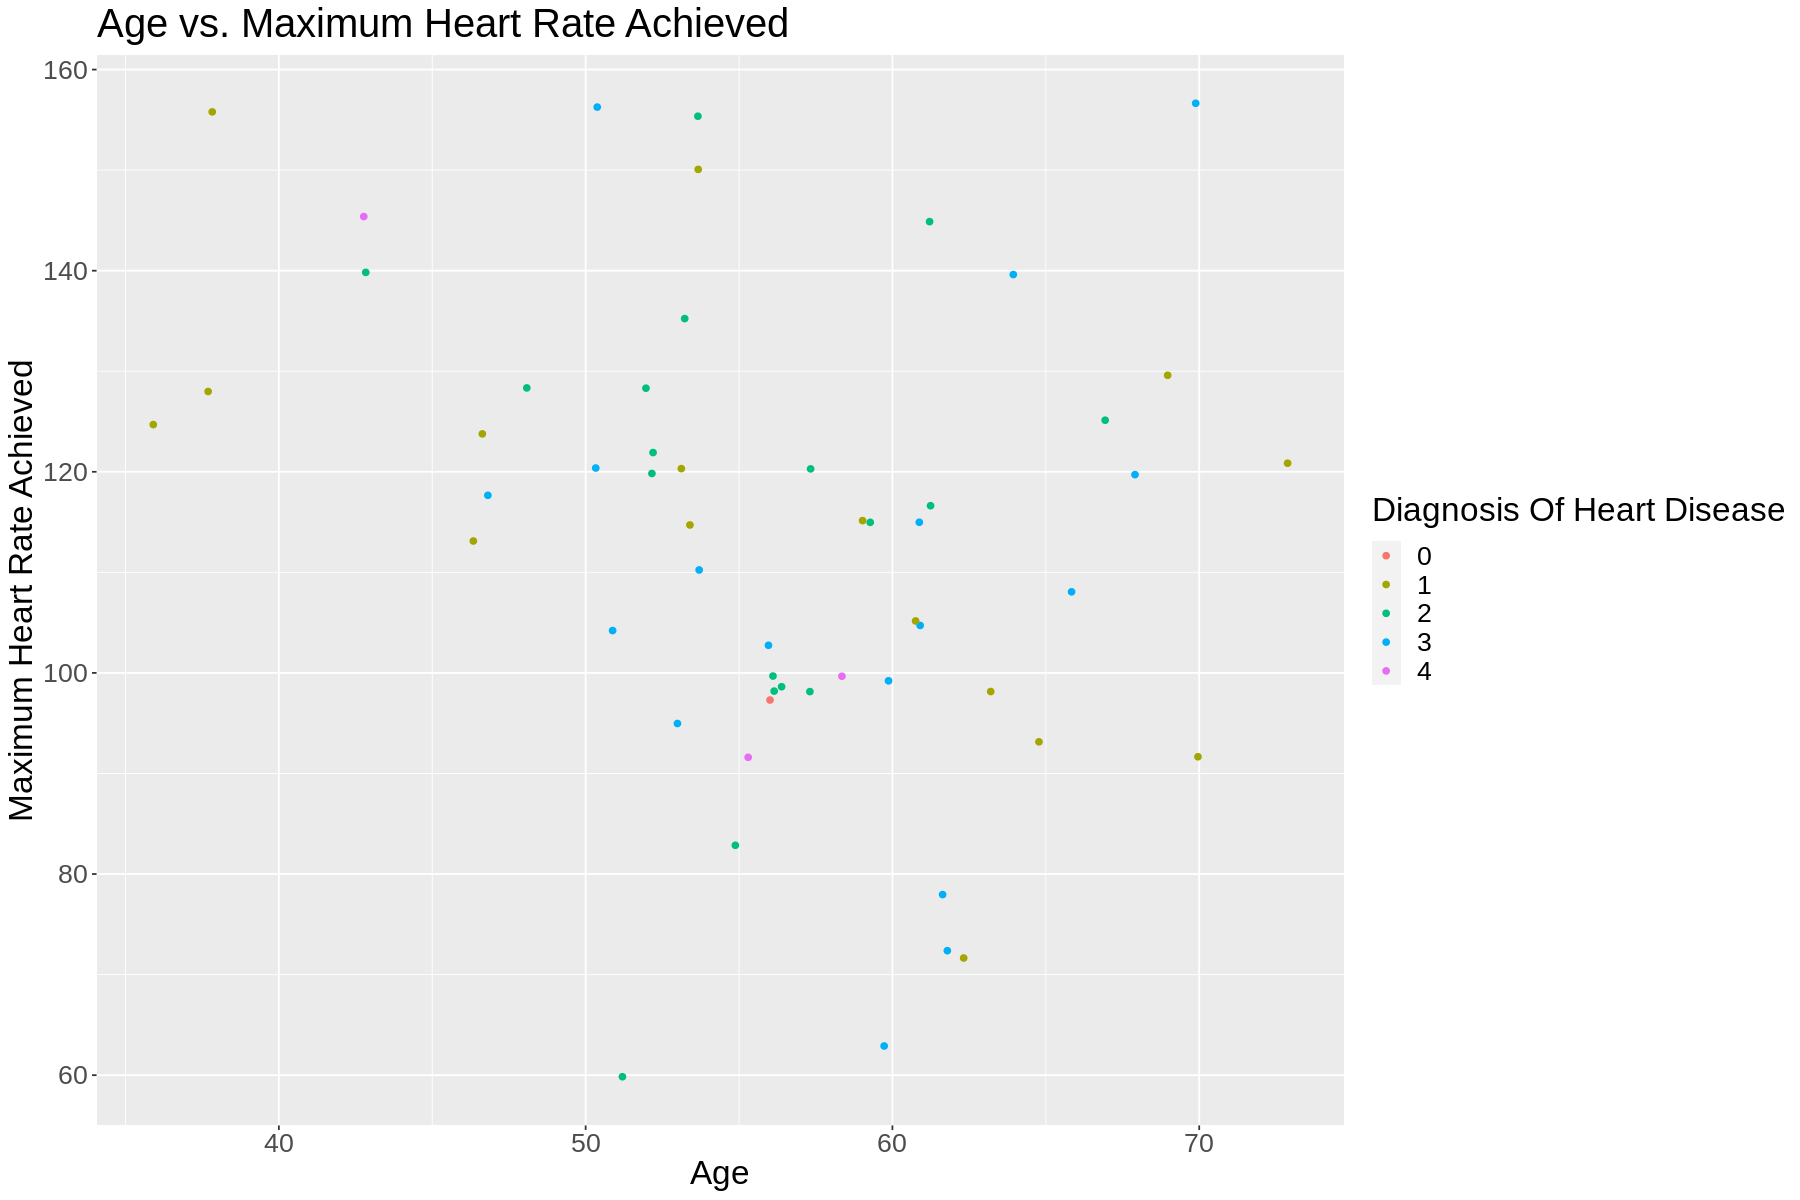

In [264]:
# Plot for age vs. maximum heart rate achieved

options(repr.plot.width = 15, repr.plot.height = 10)

max_hr_plot <- heart_disease_data %>%
                    ggplot(aes(x = age, y = max_hr, color = diagnosis))+
                    geom_point(position = "jitter")+
                    labs(x = "Age", y = "Maximum Heart Rate Achieved", colour = "Diagnosis Of Heart Disease")+
                    ggtitle("Age vs. Maximum Heart Rate Achieved")+
                    theme(text = element_text(size = 20))+
                    scale_y_continuous(labels = scales::comma)
max_hr_plot

METHODS

We will use KNN classification to predict the diagnosis.We will create a classifier, tune the classifier and visualize the results.

We will use the variables: age, sex, chest_pain_type, resting_BP, rest_ecg, max_hr, ex_angina, st_depression, slope_st, thal to predict diagnosis.

EXPECTED OUTCOMES / SIGNIFICANCE